# import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Core data processing and visualization
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import time
from collections import defaultdict

# TensorFlow for TensorBoard processing
import tensorflow as tf
from tensorflow.python.framework.errors_impl import DataLossError

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All imports successful!")

All imports successful!


# Utils

In [4]:
def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Step', 'Tag', 'Value'])
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")

def tensorboard_to_separate_csv(event_file, output_dir):
    """
    Convert TensorBoard event file to separate CSV files for each metric.
    
    Args:
        event_file (str): Path to the TensorBoard event file
        output_dir (str): Directory where CSV files should be saved
    """
    tag_data = defaultdict(list)

    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            try:
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        tag = v.tag
                        value = v.simple_value
                        step = e.step
                        tag_data[tag].append([step, value])
            except Exception as record_error:
                print(f"Skipped a corrupt record in file: {event_file}")
    except DataLossError:
        print(f"Encountered DataLossError. Possibly due to incomplete writes in file: {event_file}")

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")

def is_file_stable(file_path, wait_time=1.0):
    """Check if a file is stable (not being written to)."""
    initial_size = os.path.getsize(file_path)
    time.sleep(wait_time)
    final_size = os.path.getsize(file_path)
    return initial_size == final_size

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Process all TensorBoard files in a directory structure.
    
    Args:
        parent_dir (str): Parent directory containing TensorBoard event files
        output_parent_dir (str): Parent directory where CSV files should be saved
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")

# define a rolling window correlation function
from scipy.stats import pearsonr

def check_percentage_of_above_threshold(array, threshold, prop):
    proportion = np.mean(array > threshold)
    if proportion >= prop:
        return 1
    elif np.mean(array < threshold) >= prop:
        return -1
    else:
        return 0

def rolling_window_correlation(x, y, window):
    """
    Calculate the rolling window correlation and p-value between two 1D arrays.

    Args:
        x (array-like): First time series.
        y (array-like): Second time series.
        window (int): Window size for rolling correlation.

    Returns:
        tuple: (corrs, pvals)
            corrs: np.ndarray of correlation coefficients, length = len(x) - window + 1
            pvals: np.ndarray of p-values, same length
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    if window < 1 or window > len(x):
        raise ValueError("Window size must be between 1 and the length of the input arrays.")

    corrs = []
    pvals = []
    prop =[]
    for i in range(len(x) - window + 1):
        x_win = x[i:i+window]
        y_win = y[i:i+window]
        # Remove nan pairs
        mask = ~np.isnan(x_win) & ~np.isnan(y_win)
        if np.sum(mask) < 2:
            corrs.append(np.nan)
            pvals.append(np.nan)
            prop.append(np.nan)
        else:
            r, p = pearsonr(x_win[mask], y_win[mask])
            corrs.append(r)
            pvals.append(p)
            prop.append(check_percentage_of_above_threshold(x_win[mask], 0.3, 0.6))
    return np.array(corrs), np.array(pvals), np.array(prop)


def trim_and_calculate_mean(array_list):
    """
    Trim arrays to the same length and calculate mean.
    
    Args:
        array_list: List of arrays to process
        
    Returns:
        numpy.ndarray: Array of trimmed arrays
    """
    min_length = min(len(arr) for arr in array_list)
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    return np.array(trimmed_arrays)

def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data
        alpha (float): The smoothing factor (0 < alpha <= 1)

    Returns:
        numpy.ndarray: The EMA values
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data
        window_size (int): The size of the rolling window

    Returns:
        numpy.ndarray: The rolling average values
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')



# Load data

In [5]:
df

,epoch,agent_id,partner_kind,version,q_val_forward,q_val_backward,q_val_step_left,q_val_step_right,q_val_attack,weight_facing_stag,weight_facing_hare
0,10,0,AgentKindA,upper,0.024645,0.106456,0.122141,0.095715,0.186767,0.197461,0.202748


In [35]:
epoch = 30010
dfB = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{0}_partner_AgentKindB_upper.csv')
dfA = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{0}_partner_AgentKindA_upper.csv')


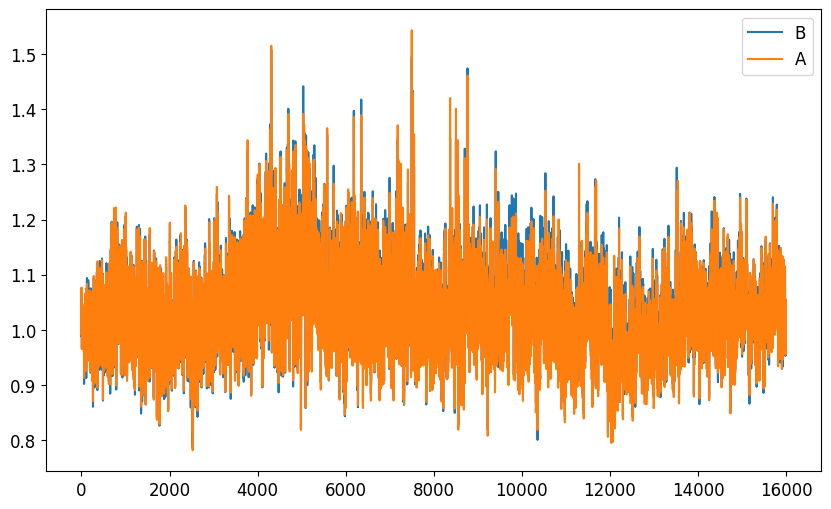

In [18]:
line_B = []
line_A = []
for epoch in range(10, 160000, 10):
    dfB = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{0}_partner_AgentKindB_upper.csv')
    dfA = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{0}_partner_AgentKindA_upper.csv')
    line_B.append((dfB['weight_facing_stag']/dfB['weight_facing_hare']).mean())
    line_A.append((dfA['weight_facing_stag']/dfA['weight_facing_hare']).mean())

plt.plot(line_B, label='B')
plt.plot(line_A, label='A')
plt.legend()
plt.show()

In [40]:
(dfB['weight_facing_stag']/dfB['weight_facing_hare']).mean()

np.float64(0.8683697880422421)

In [41]:
(dfA['weight_facing_stag']/dfA['weight_facing_hare']).mean()


np.float64(0.8524019344577337)

In [ ]:
# for simple probe test
folders = [
#     "test_vis4_area_attack_3a_Nov04_with_epsilon0_stag24_20251106-171737",
#     # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_20251107-010519",
    
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
#    #"test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_with_wound_indicator_20251106-100222",
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145"
# # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_20251110-233256"
"test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_size9_20251112-125150"
]

num_tests_lst = [60000, 60000, 60000]
test_interval = 10
num_tests = 16000
num_a = 2

res = {'test_ind': [], 'cond_idx': []}
for idx, folder in enumerate(folders):
    if len(folders) > 1:
        num_tests = num_tests_lst[idx]
    for test_ind in range(1, num_tests):
        agent_data = {}
        for agent_ind in range(0, num_a):
            for cond in ['upper', 'lower']:
                epoch = int(test_ind * test_interval)
                df = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_partner_AgentKinDA_{cond}.csv')
                for col in df.columns[4:]:
                    if col not in list(agent_data.keys()):
                        agent_data[col] = [df[col].mean()]
                    else:
                        agent_data[col].append(df[col].mean())
        if test_ind == 1 and idx == 0:
            for key, item in agent_data.items():
                res[key] = [np.mean(item)]
        else:
            for key, item in agent_data.items():
                res[key].append(np.mean(item))
                
        
    res['test_ind'].extend([x for x in range(1, num_tests)])
    res['cond_idx'].extend([idx for _ in range(1, num_tests)])
res = pd.DataFrame(res)

In [108]:
# for composite probe tests
folders = [
#     "test_vis4_area_attack_3a_Nov04_with_epsilon0_stag24_20251106-171737",
#     # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_20251107-010519",
    
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
#    #"test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_with_wound_indicator_20251106-100222",
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145"
# # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_20251110-233256"
"test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_size9_20251112-125150"
]

num_tests_lst = [60000, 60000, 60000]
test_interval = 10
num_tests = 89000
num_a = 2

res_partnerA = {'test_ind': [], 'cond_idx': []}
res_partnerB = {'test_ind': [], 'cond_idx': []}
for idx, folder in enumerate(folders):
    if len(folders) > 1:
        num_tests = num_tests_lst[idx]
    for test_ind in range(1, num_tests):
        agent_data_partner_A = {}
        agent_data_partner_B = {}
        for agent_ind in range(0, num_a):
            # agent_ind = 2
            for cond in ['upper', 'lower']:
                epoch = int(test_ind * test_interval)
                df_partner_A = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_partner_AgentKinDA_{cond}.csv')
                df_partner_B = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_partner_AgentKinDB_{cond}.csv')
                for col in df_partner_A.columns[4:]:
                    if col not in list(agent_data_partner_A.keys()):
                        agent_data_partner_A[col] = [df_partner_A[col].mean()]
                    else:
                        agent_data_partner_A[col].append(df_partner_A[col].mean())
                for col in df_partner_B.columns[4:]:
                    if col not in list(agent_data_partner_B.keys()):
                        agent_data_partner_B[col] = [df_partner_B[col].mean()]
                    else:
                        agent_data_partner_B[col].append(df_partner_B[col].mean()) 
            
        if test_ind == 1 and idx == 0:
            for key, item in agent_data_partner_A.items():
                res_partnerA[key] = [np.mean(item)]
            for key, item in agent_data_partner_B.items():
                res_partnerB[key] = [np.mean(item)]
        else:
            for key, item in agent_data_partner_A.items():
                res_partnerA[key].append(np.mean(item))
            for key, item in agent_data_partner_B.items():
                res_partnerB[key].append(np.mean(item))
                
        
    res_partnerA['test_ind'].extend([x for x in range(1, num_tests)])
    res_partnerA['cond_idx'].extend([idx for _ in range(1, num_tests)])
    res_partnerB['test_ind'].extend([x for x in range(1, num_tests)])
    res_partnerB['cond_idx'].extend([idx for _ in range(1, num_tests)])
res_partnerA = pd.DataFrame(res_partnerA)
res_partnerA['partner'] = 'A'
res_partnerB = pd.DataFrame(res_partnerB)
res_partnerB['partner'] = 'B'
res = pd.concat([res_partnerA, res_partnerB])

In [ ]:
for key, item in res.items():
    print(len(item))

# Add rolling metrics

In [24]:
metrics = ['q_val_step_left',
       'q_val_step_right', 'q_val_attack', 'weight_facing_stag',
       'weight_facing_hare', 'ratio_facing_stag_vs_hare']
wsize = 20
res_rolling = res.copy()
res_rolling['ratio_facing_stag_vs_hare'] = res_rolling['weight_facing_stag']/res_rolling['weight_facing_hare']
for metric in metrics:
    res_rolling[f'{metric}_rolling'] = res_rolling.groupby('cond_idx')[metric].rolling(wsize).mean().reset_index(drop=True)
    

In [109]:
metrics = ['q_val_step_left',
       'q_val_step_right', 'q_val_attack', 'weight_facing_stag',
       'weight_facing_hare', 'ratio_facing_stag_vs_hare']
wsize = 100
res_rolling_partnerA = res_partnerA.copy()
res_rolling_partnerA['ratio_facing_stag_vs_hare'] = res_rolling_partnerA['weight_facing_stag']/res_rolling_partnerA['weight_facing_hare']
for metric in metrics:
    res_rolling_partnerA[f'{metric}_rolling'] = res_rolling_partnerA.groupby('cond_idx')[metric].rolling(wsize).mean().reset_index(drop=True)



In [110]:
metrics = ['q_val_step_left',
       'q_val_step_right', 'q_val_attack', 'weight_facing_stag',
       'weight_facing_hare', 'ratio_facing_stag_vs_hare']
wsize = 100
res_rolling_partnerB = res_partnerB.copy()
res_rolling_partnerB['ratio_facing_stag_vs_hare'] = res_rolling_partnerB['weight_facing_stag']/res_rolling_partnerB['weight_facing_hare']
for metric in metrics:
    res_rolling_partnerB[f'{metric}_rolling'] = res_rolling_partnerB.groupby('cond_idx')[metric].rolling(wsize).mean().reset_index(drop=True)



In [208]:
res_rolling

,test_ind,cond_idx,q_val_forward,q_val_backward,q_val_step_left,q_val_step_right,q_val_attack,weight_facing_stag,weight_facing_hare,ratio_facing_stag_vs_hare,q_val_forward_rolling,q_val_backward_rolling,q_val_step_left_rolling,q_val_step_right_rolling,q_val_attack_rolling,weight_facing_stag_rolling,weight_facing_hare_rolling,ratio_facing_stag_vs_hare_rolling
0,1,0,0.029953,0.043160,0.037559,0.040600,0.186922,0.194552,0.193472,1.005583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,0.060310,0.075341,0.067530,0.080932,0.239979,0.194000,0.192993,1.005215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,0.230894,0.218776,0.238991,0.249490,0.390607,0.195551,0.195176,1.001921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,0.288528,0.283341,0.276123,0.274713,0.490293,0.190028,0.189915,1.000595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,0.548752,0.534809,0.559867,0.540130,0.789062,0.190524,0.190194,1.001733,0.231687,0.231085,0.236014,0.237173,0.419373,0.192931,0.192350,1.003009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,0,5.713761,5.509821,5.591926,5.576272,5.506036,0.245749,0.164458,1.494298,5.744944,5.480419,5.592060,5.529015,5.477608,0.241436,0.164617,1.469539
495,496,0,5.633429,5.454468,5.595095,5.452744,5.499986,0.248519,0.157892,1.573976,5.740167,5.472989,5.609194,5.518495,5.496113,0.244591,0.162185,1.510607
496,497,0,5.673571,5.478404,5.533324,5.497814,5.480807,0.240171,0.161251,1.489419,5.725199,5.483889,5.574585,5.526321,5.484426,0.240850,0.163132,1.477684
497,498,0,5.621574,5.424801,5.553413,5.455621,5.431028,0.238985,0.167100,1.430193,5.693166,5.470323,5.571557,5.507100,5.484082,0.241764,0.162743,1.486383


# Plot

In [ ]:
sns.lineplot(x = 'test_ind', y='weight_facing_hare_rolling', data=res_rolling, label='weight_facing_hare')
sns.lineplot(x = 'test_ind', y='weight_facing_stag_rolling', data=res_rolling, label='weight_facing_stag')


In [9]:
mapping = {
    0: "experimental, eps=0.05",
    1: "experimental, eps=1",
    2: "control, eps=1"
}

res_rolling["cond"] = res_rolling["cond_idx"].map(mapping)

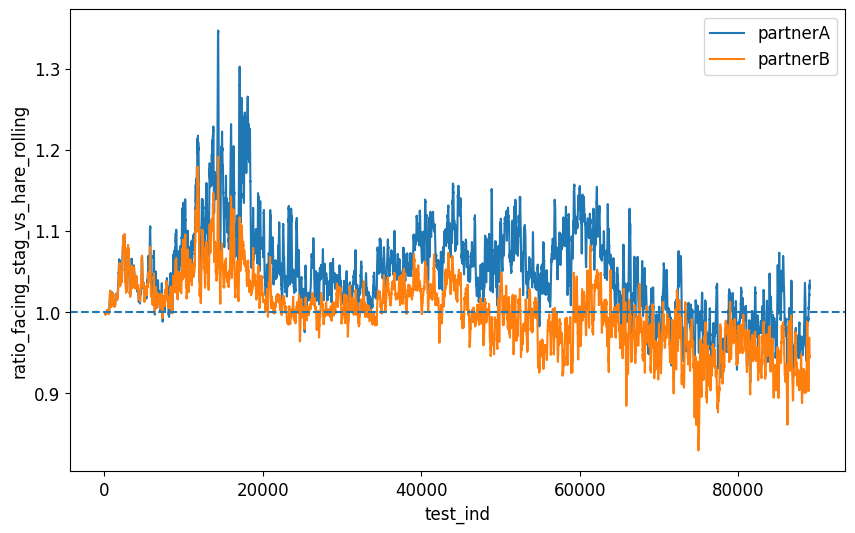

In [111]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
plt.axhline(y=1, linestyle='--')


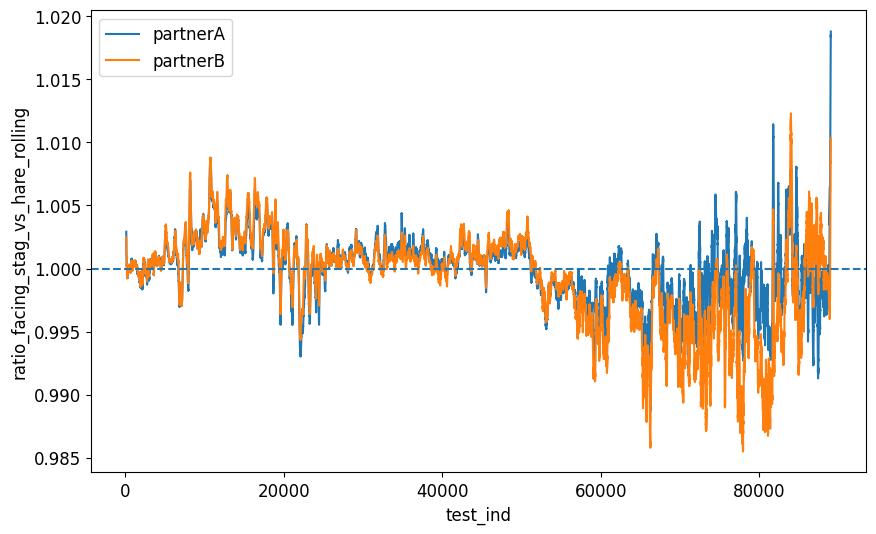

In [107]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
plt.axhline(y=1, linestyle='--')


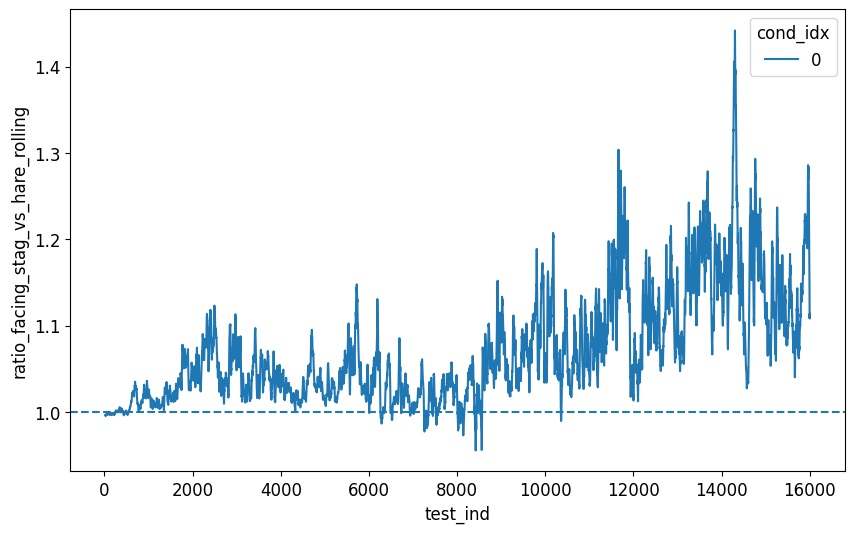

In [32]:
sns.lineplot(x='test_ind', y='ratio_facing_stag_vs_hare_rolling', hue='cond_idx', data=res_rolling_partnerA, )
plt.axhline(y=1, linestyle='--')
# plt.legend(labels=['experimental, eps=0.05', 'experimental, eps=1', 'control, eps=1'])

# Convert tensorboard logger files


In [11]:
parent_dir = '../runs/' # runs_p48
output_dir = 'res/runs/' # res/runs_p48_a2_deterministic
process_tensorboard_results(parent_dir, output_dir)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Data for tag 'loss' has been written to res/runs/test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145/loss_data.csv
Data for tag 'score' has been written to res/runs/test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145/score_data.csv
Data for tag 'epsilon' has been written to res/runs/test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145/epsilon_data.csv
Data for tag 'Agent_0/attacks_to_hares' has been written to res/runs/test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145/Agent_0_attacks_to_hares_data.csv
Data for tag 'Agent_0/attacks_to_stags' has been written to res/runs/test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145/Agent_0_attacks_to_stags_data.csv
Data for tag 'Agent_0/punishments_given' has been written to res/runs/test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20

Text(0, 0.5, 'Number of attacks to hares/stags')

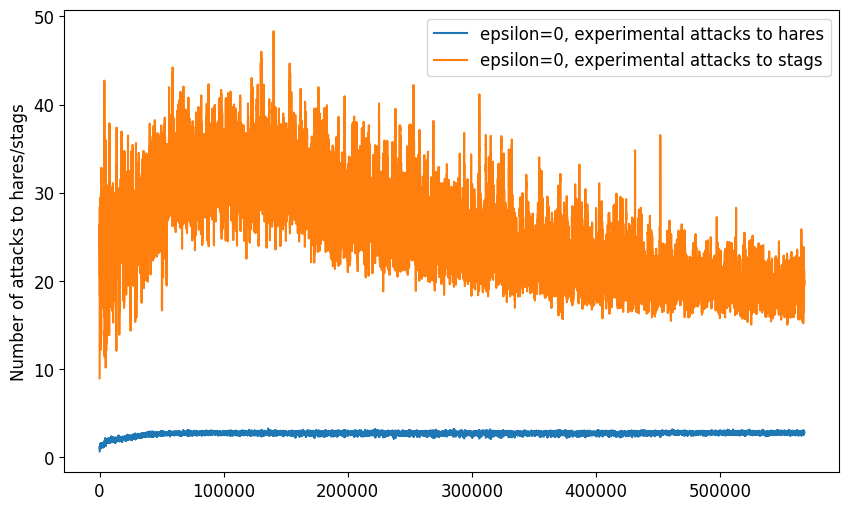

In [12]:
## Plot stag attacks vs hares attacks

folders = [
    # "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
    "test_vis4_area_attack_3a_Nov04_with_epsilon0_stag24_20251106-171737"
]

condition_names = [
    # 'epsilon=1, experimental',
    'epsilon=0, experimental'
]

wsize = 100
df_lst_attacks_to_hares = []
df_lst_attacks_to_stags = []
for folder, condition_name in zip(folders, condition_names):
    df_attacks_to_hares = pd.read_csv(f'res/runs/{folder}/Mean_mean_attacks_to_hares_data.csv')
    val_attacks_to_hares = df_attacks_to_hares['Value'].rolling(wsize).mean().values
    df_lst_attacks_to_hares.append(val_attacks_to_hares)

    df_attacks_to_stags = pd.read_csv(f'res/runs/{folder}/Mean_mean_attacks_to_stags_data.csv')
    val_attacks_to_stags = df_attacks_to_stags['Value'].rolling(wsize).mean().values
    df_lst_attacks_to_stags.append(val_attacks_to_stags)

for i in range(len(df_lst_attacks_to_hares)):
    plt.plot(df_lst_attacks_to_hares[i], label=condition_names[i]+' attacks to hares')
    plt.plot(df_lst_attacks_to_stags[i], label=condition_names[i]+' attacks to stags')
plt.legend()
plt.ylabel('Number of attacks to hares/stags')


Text(0, 0.5, 'Number of stags/hares defeated')

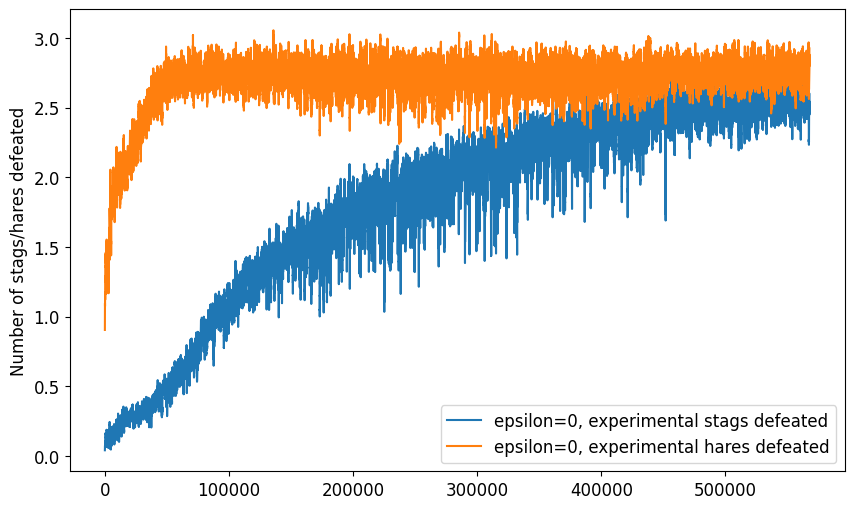

In [13]:
## Plot stag defeated vs hares defeated

folders = [
    # "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
    "test_vis4_area_attack_3a_Nov04_with_epsilon0_stag24_20251106-171737"
]

condition_names = [
    # 'epsilon=1, experimental',
    'epsilon=0, experimental'
]

wsize = 200
df_lst_stags_defeated = []
df_lst_hares_defeated = []
for folder, condition_name in zip(folders, condition_names):
    df_stags_defeated = pd.read_csv(f'res/runs/{folder}/Mean_mean_stags_defeated_data.csv')
    val_stags_defeated = df_stags_defeated['Value'].rolling(wsize).mean().values
    df_lst_stags_defeated.append(val_stags_defeated)

    df_hares_defeated = pd.read_csv(f'res/runs/{folder}/Mean_mean_hares_defeated_data.csv')
    val_hares_defeated = df_hares_defeated['Value'].rolling(wsize).mean().values
    df_lst_hares_defeated.append(val_hares_defeated)

for i in range(len(df_lst_stags_defeated)):
    plt.plot(df_lst_stags_defeated[i], label=condition_names[i]+' stags defeated')
    plt.plot(df_lst_hares_defeated[i], label=condition_names[i]+' hares defeated')
plt.legend()
plt.ylabel('Number of stags/hares defeated')
